In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical, Normal

import itertools

import sys
sys.path.insert(0, './../libraries/')

import importance_sample_lib as imp_lib
import galaxy_experiments_lib as galaxy_lib

import sys
sys.path.insert(0, '../../../celeste_net/')
import celeste_net 

from celeste_net import OneGalaxyVAE


from datasets import Synthetic

# Load data

In [2]:
side_len = 31

In [3]:
galaxy_data = Synthetic(side_len, min_galaxies=3, max_galaxies=3, num_bands=5,
                        num_images=100, brightness = 5000)

In [4]:
train_loader, test_loader = galaxy_lib.get_train_test_data(galaxy_data, batch_size=10)

In [5]:
for batch_idx, data in enumerate(train_loader):
    train_data_batch1 = data
    break
    
images_batch1 = train_data_batch1['image']
backgrounds_batch1 = train_data_batch1['background']

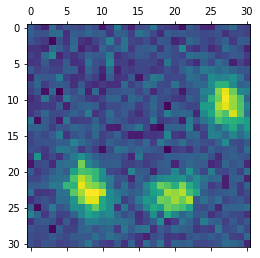

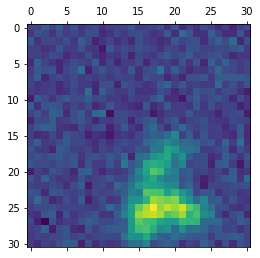

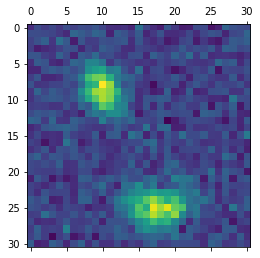

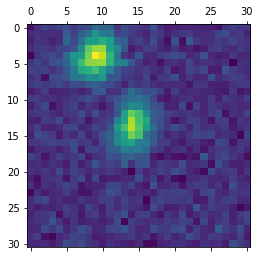

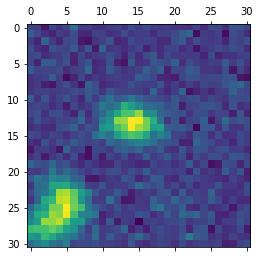

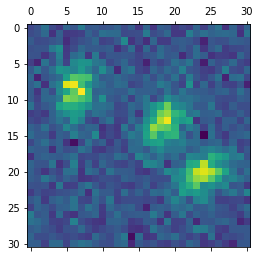

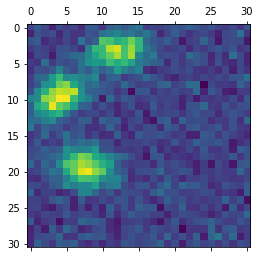

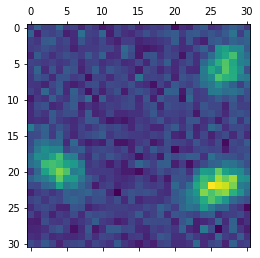

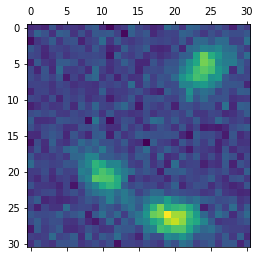

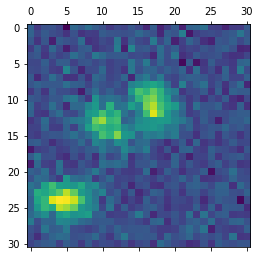

In [6]:
for i in range(images_batch1.shape[0]): 
    plt.matshow(images_batch1[i, 0, :, :])

In [7]:
# The VAE
galaxy_vae = celeste_net.OneGalaxyVAE(side_len)

In [8]:
galaxy_rnn = galaxy_lib.CelesteRNN(side_len, one_galaxy_vae=galaxy_vae)

In [9]:
state_dict = torch.load('../galaxy_results/multiple_detections/' + \
                        'galaxy_vae_3detections_imp_sample_off_epoch20.dat', 
                        map_location='cpu')
galaxy_rnn.load_state_dict(state_dict, strict = True)

In [10]:
galaxy_rnn.eval(); 
galaxy_rnn.one_galaxy_vae.eval(); 

In [11]:
_, loss, _ = imp_lib.get_importance_sampled_galaxy_loss(galaxy_rnn, images_batch1, backgrounds_batch1,
                                            use_importance_sample = True,
                                            use_baseline = False,
                                            max_detections = 3)

print(loss)

class weights:  tensor(1.00000e-02 *
       [ 0.9611,  0.5892,  1.5331,  0.0401,  1.4192,  0.3815,  1.7704,
         1.4128,  7.2589,  0.8629])
imp weights:  tensor(1.00000e-02 *
       [ 1.2974,  0.9516,  1.6896,  0.6904,  1.7393,  0.6840,  1.4242,
         1.6817,  2.9945,  1.6663])
importance_reweighting_iter tensor([ 0.7408,  0.6191,  0.9073,  0.0581,  0.8159,  0.5578,  1.2431,
         0.8401,  2.4241,  0.5179])
class weights:  tensor(1.00000e-03 *
       [ 4.0743,  0.0031,  0.0018,  0.0040,  0.0037,  1.5409,  0.0044,
         3.8398,  1.7675,  4.2242])
imp weights:  tensor(1.00000e-02 *
       [ 0.6196,  2.5178,  1.9805,  1.1498,  2.0970,  0.0615,  0.3140,
         0.5255,  0.0761,  0.3224])
importance_reweighting_iter tensor([ 4.8714e-01,  7.6571e-05,  8.4609e-05,  1.9977e-05,  1.4577e-04,
         1.3972e+00,  1.7494e-03,  6.1380e-01,  5.6299e+00,  6.7845e-01])
class weights:  tensor(1.00000e-03 *
       [ 0.0018,  0.0026,  0.0019,  0.0058,  0.0024,  5.6220,  0.0029,
         0

In [19]:
_, loss, _ = imp_lib.get_importance_sampled_galaxy_loss(galaxy_rnn, images_batch1, backgrounds_batch1,
                                            use_importance_sample = False,
                                            use_baseline = False,
                                            max_detections = 3)

print(loss)

tensor(1.00000e-02 *
       [ 3.7995,  2.7932,  2.6498,  1.4397,  5.6453,  0.1340,  1.5638,
         0.6102,  0.5930,  0.9399])
tensor(1.00000e-02 *
       [ 3.7995,  2.7932,  2.6498,  1.4397,  5.6453,  0.1340,  1.5638,
         0.6102,  0.5930,  0.9399])
tensor([ 0.1459,  0.1814,  0.0125,  0.4246,  0.0316,  0.0031,  0.0570,
         0.0094,  0.0085,  0.0616])
tensor([ 0.1459,  0.1814,  0.0125,  0.4246,  0.0316,  0.0031,  0.0570,
         0.0094,  0.0085,  0.0616])
tensor([ 0.2835,  0.4621,  0.0084,  0.0009,  0.0952,  0.0264,  0.7850,
         0.0996,  0.0028,  0.3829])
tensor([ 0.2835,  0.4621,  0.0084,  0.0009,  0.0952,  0.0264,  0.7850,
         0.0996,  0.0028,  0.3829])
tensor(87278.4688)


In [21]:
pixel_probs = galaxy_rnn.get_pixel_probs(resid_image = images_batch1 - backgrounds_batch1, 
                                         var_so_far = backgrounds_batch1)

In [22]:
torch.max(pixel_probs, dim = 1)

(tensor([ 0.0561,  0.1195,  0.0458,  0.1877,  0.0890,  0.0059,  0.0555,
          0.1186,  0.0257,  0.1403]),
 tensor([ 140,  329,  284,  342,   65,  219,  408,  155,   61,  441]))

In [23]:
prob_off = pixel_probs.detach()[:, -1].view(-1, 1)

prob off:  [1.1164569e-16]


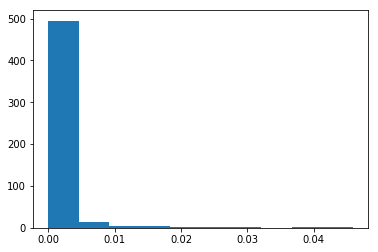

In [24]:
n = 2
plt.hist(pixel_probs[n, :].detach()); 
print('prob off: ', prob_off[n].detach().numpy())

In [25]:
attn_offset = galaxy_rnn.attn_offset

importance_weights = \
    imp_lib.get_importance_weights(torch.abs(images_batch1 - backgrounds_batch1), attn_offset, prob_off)

prob off:  [1.1164569e-16]


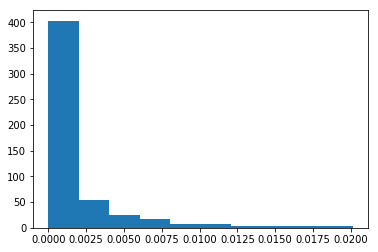

In [26]:
plt.hist(importance_weights[n, :]); 
print('prob off: ', prob_off[n].detach().numpy())

In [45]:
_, loss, recon_means = imp_lib.get_importance_sampled_galaxy_loss(galaxy_rnn, images_batch1, backgrounds_batch1,
                                    use_importance_sample = True,
                                    use_baseline = False,
                                    max_detections = 3)

tensor([ 0.0078,  0.0004,  0.0005,  0.1431,  0.0005,  0.0001,  0.0005,
         0.0001,  0.0002,  0.0008])
tensor([ 1.1717e-06,  1.9315e-07,  1.4735e-06,  1.3268e-03,  8.3023e-08,
         3.1364e-08,  3.9335e-08,  1.0312e-08,  2.9321e-08,  6.6398e-08])
tensor([ 9.9138e-11,  2.8117e-11,  5.6606e-06,  1.1513e-04,  8.1183e-07,
         1.6788e-08,  4.7148e-12,  3.7675e-12,  3.3071e-09,  5.3198e-12])
torch.Size([10])
torch.Size([10])
torch.Size([10])


In [40]:
loss

tensor(26485.0234)

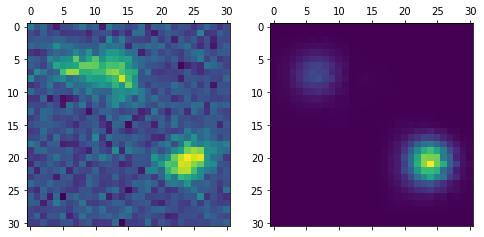

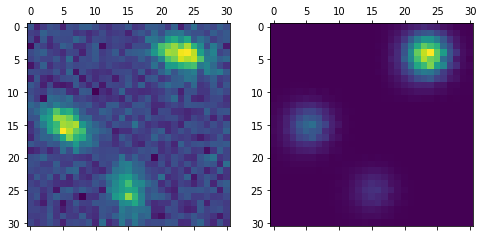

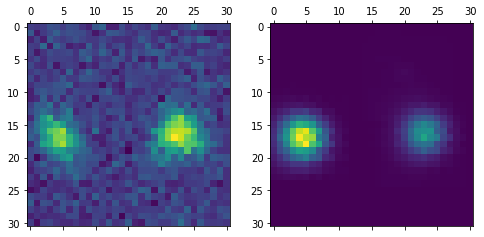

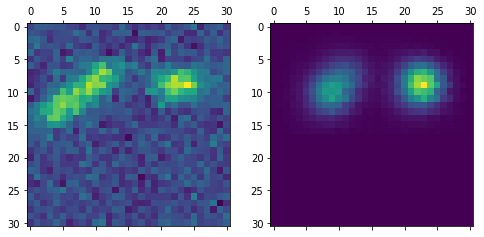

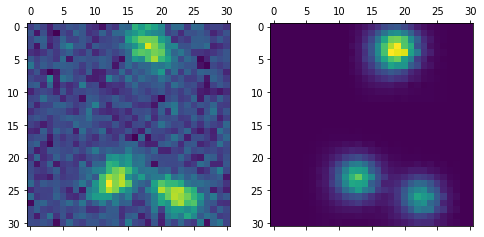

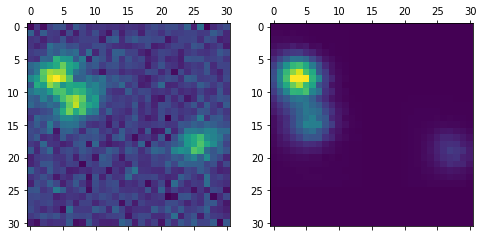

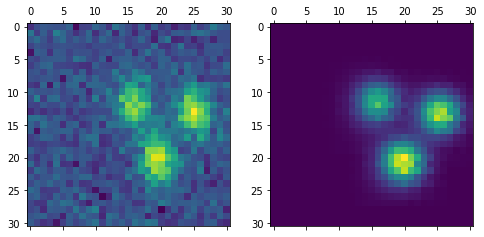

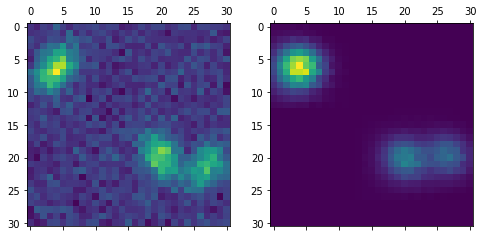

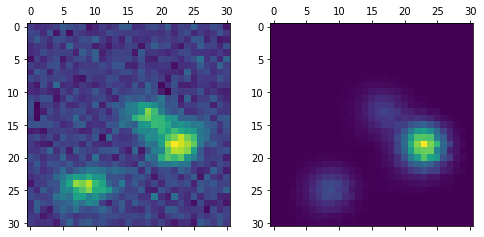

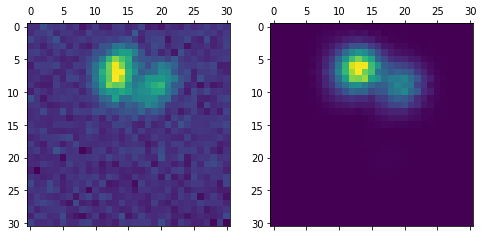

In [41]:
figsize = 8

for n in range(images_batch1.shape[0]): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(images_batch1[n, 0, :, :].squeeze())
    axarr[1].matshow(recon_means.detach()[n, 0, :, :].squeeze())


In [42]:
# loss_array_imp_sample = np.load('../galaxy_results/multiple_detections/galaxy_vae_batch_losses_array.npy')
loss_array_default = np.load('../galaxy_results/multiple_detections/' + 
                             'galaxy_vae_3detections_imp_sample_off_batch_losses_array.npy')

In [43]:
fontsize = 18

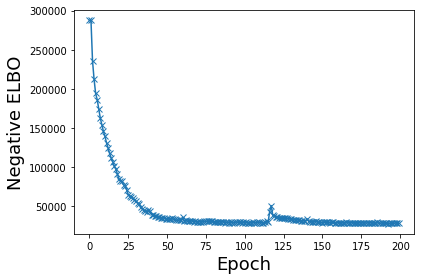

In [44]:
# plt.plot(loss_array_imp_sample, '-x')
plt.plot(loss_array_default, '-x')

plt.xlabel('Epoch', fontsize = fontsize)
plt.ylabel('Negative ELBO', fontsize = fontsize)
# plt.legend(('REINFORCE + CV', 'Rao-Blackwellized'))
plt.tight_layout()